
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries

inputs required: 
  * Historical DWTs
  * Historical AWT and IWT
  * Synthetic timeseries of AWT and IWT
  * Historical wave families 
  * Historical intradaily hydrograph parameters
  * TCs waves
  
in this notebook:
  * Fit a multivariate extreme model for the waves associated to each DWT
  * Generate synthetic time series of wave conditions
  * Validate the synthetic waves by means of mean distributions, annual maxima, and peak over-threshold methods


### Workflow:

<div>
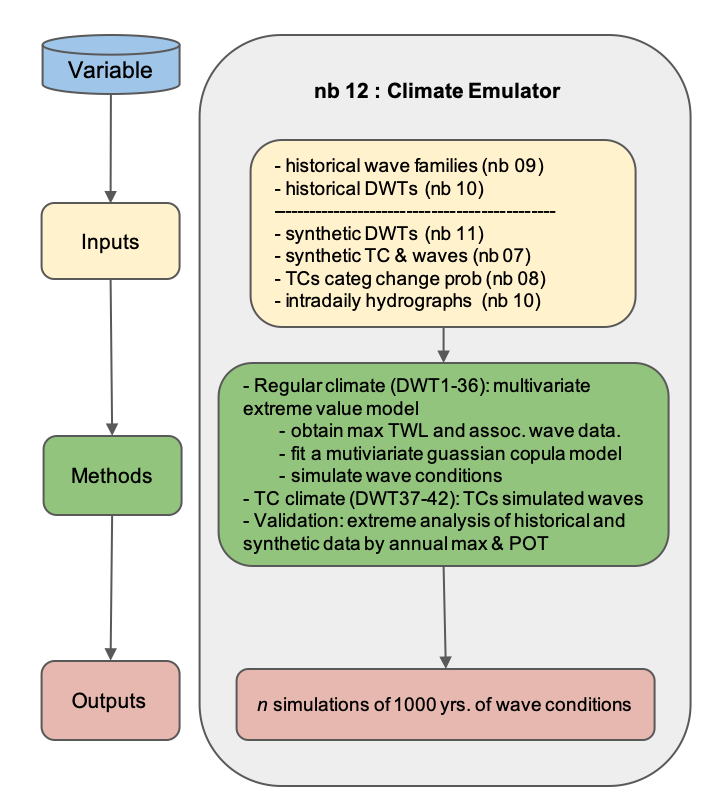
</div>


The synthetic generation of wave conditions on a regular climate (DWT1-36) is based on the work of Rueda et al. 2017. The probability of SW1, SW2, and SEA components being present (1) or not present (0) at the time of observed peak TWLproxy was used to create eight potential sea-states within each DWT (000, 100, 010, 001, 110, 101, 011, 111) defined by Bernoulli distributions . For each hydrograph produced in the simulations of climate, a random pick from the appropriate Bernoulli distribution determined which sea state was present during that hydrograph. A subsequent random pick from the assigned sea state’s marginal distributions defined the waves at the maximum TWL peak within the simulated hydrograph.

The marginal distributions of waves and surge levels were associated with each other using multivariate gaussian copulas. The copulas define the dependence structure, or joint probabilities, between each environmental parameter within a sea state by identifying correlation matrices after transforming each marginal distribution to a uniform distribution. Identifying the correlation across all parameters through the copulas ensures that realistic combinations of compounding environmental parameters are present in the hypothetical time series (i.e., large storm waves approach from appropriate wave directions) (Masina et al. 2015; Corbella & Stretch, 2013). The marginal distributions of wave heights were defined by GEVs to allow for simulation of extremes with longer return periods than the observation period, while wave periods and directions were defined by empirical distributions constructed from observations. 

Additional parameters including τ (timing of the peak TWL within a hydrograph) and μ (area under the hydrograph) were also added to each copula and randomly sampled for each simulated hydrograph. The two parameters effectively define a trapezoidal shape for each simulated hydrograph, analogous to the storm schematization of other recent works (e.g., Poelhekke et al., 2016). Including these parameters in the copulas accounts for correlation between storminess and hydrograph shape (peaky hydrographs are commonly associated with storm conditions while more flat hydrographs typically occur during calmer conditions). The shape of the simulated hydrograph will be use to interpolate to an hourly value of the TWLproxy, and subsequently an hourly value of wave conditions *(notebook 13)*

In the case on waves associated to a TC event, the associated simulated waves from WWIII simulation that have been reconstructed in *notebook 07* are use whenever the simulated TC enters the 4 degrees radio.

At the end of the notebook the validation of the synthetic waves with the historical mean distribution and annual maxima is performed, as well as the analysis of the DWT resposible of extreme TWL events (from the historical and synthetic datasets)

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, Aggregate_WavesFamilies
from teslakit.extremes import Peaks_Over_Threshold as POT

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])



## Climate Emulator - Fitting

In [4]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)

# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}

CE.FitExtremes(DWTs_fit, WVS_fit, config)

# Load Climate Emulator
#CE.Load()

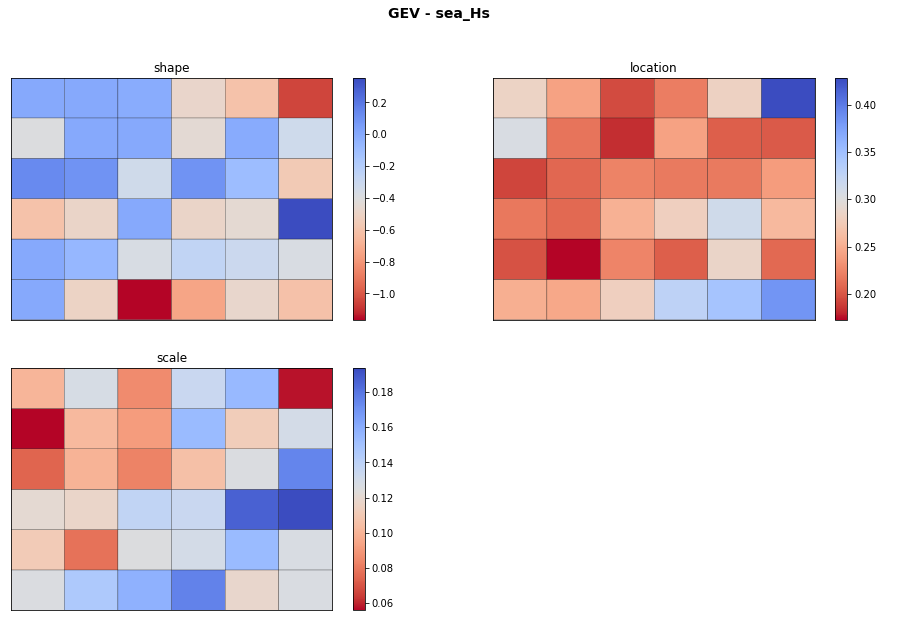

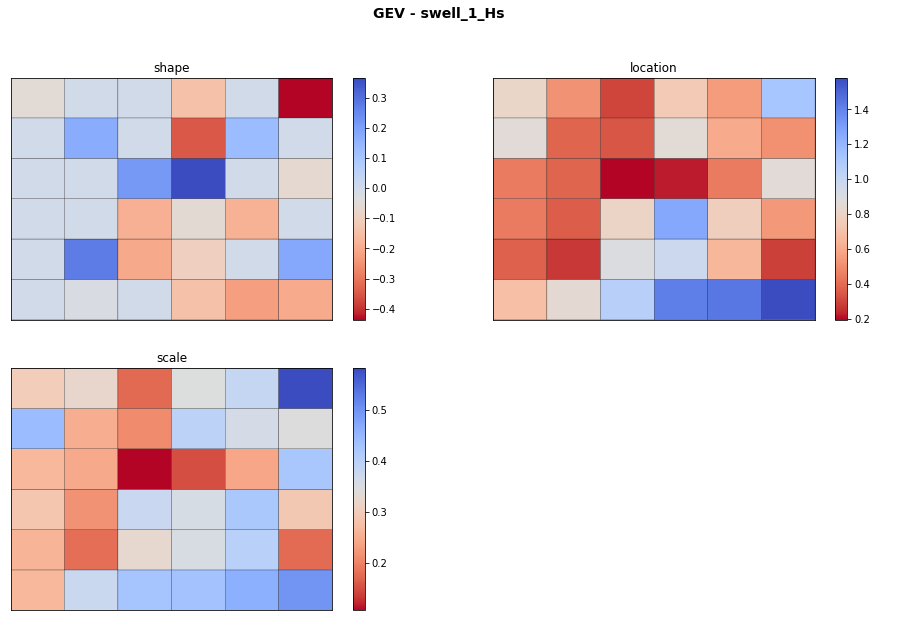

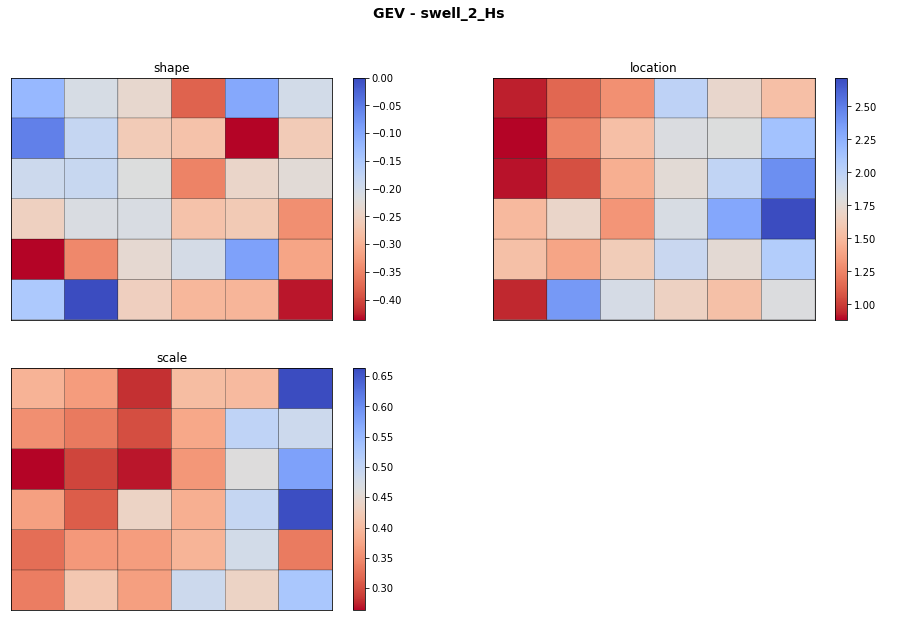

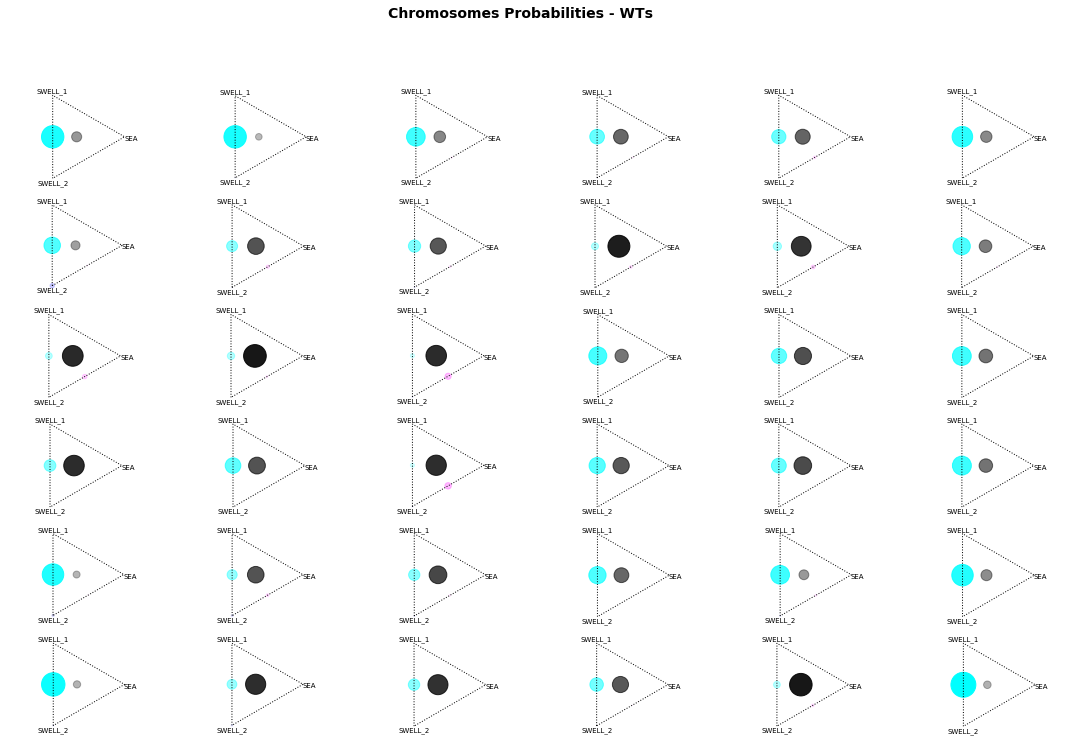

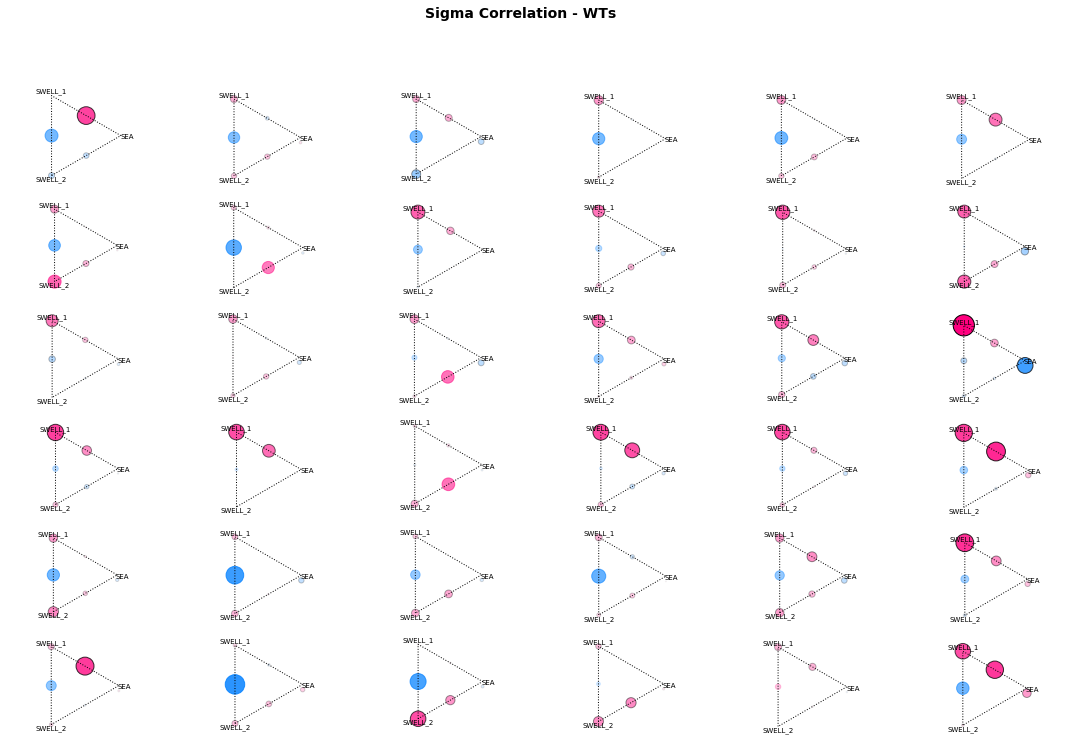

In [5]:
# Fit report figures
CE.Report_Fit();



## Climate Emulator - Simulation

In [6]:
# Select DWT series to simulate
DWTs_sim = DWTs_sim.sel(n_sim=0)

print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (time: 365243)
Coordinates:
  * time         (time) object 1700-01-01 00:00:00 ... 2700-01-01 00:00:00
Data variables:
    evbmus_sims  (time) float32 ...
Attributes:
    source:   teslakit_v0.9.1


In [7]:
# --------------------------------------
#  Climate Emulator simulation

ce_sims = 10

# Simulate waves
WVS_sim = CE.Simulate_Waves(DWTs_sim, ce_sims, filters={'hs':True, 'tp':True, 'ws':True})

# Simulate TCs and update simulated waves
TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)


# Load Climate Emulator Simulations
#WVS_sim, TCs_sim, WVS_upd = CE.LoadSim()


C.E: Sim. TCs  : 100%|██████████| 114638/114638 [00:08<00:00, 13139.84it/s]


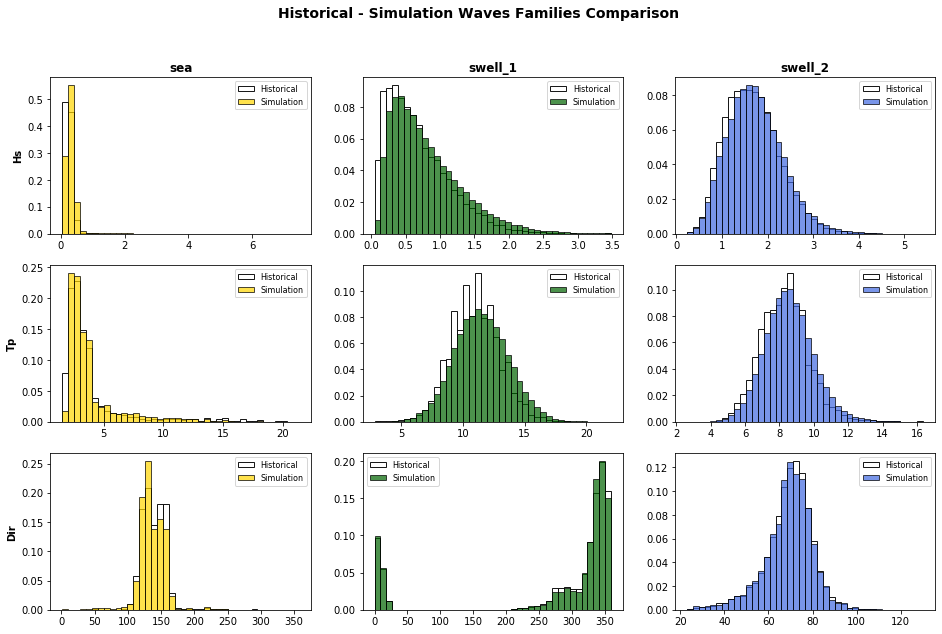

In [8]:
# Plot simulated waves parameters distribution 

Plot_Waves_Histogram_FitSim(WVS_fit, WVS_upd.isel(n_sim=0));
    

In [9]:
# --------------------------------------
#  Aggregate simulated and historical waves data

# aggregate simulation
l_wa = []
for i_sim in WVS_upd.n_sim:
    
    wa = Aggregate_WavesFamilies(WVS_upd.sel(n_sim=i_sim))
    l_wa.append(wa)
    
WVS_sim_a = xr.concat(l_wa, 'n_sim')

# aggregate historical
WVS_hist = Aggregate_WavesFamilies(WVS_fit)

# calculate Atmospheric Water Level
WVS_sim_a['AWL'] = AWL(WVS_sim_a.Hs, WVS_sim_a.Tp)
WVS_hist['AWL'] = AWL(WVS_hist.Hs, WVS_hist.Tp)



## Climate Emulator - Annual Maxima

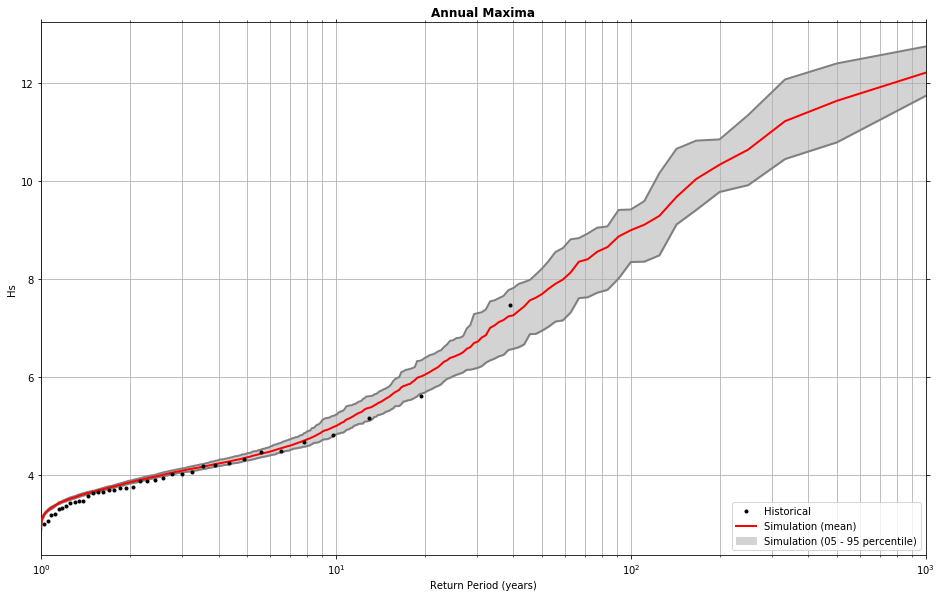

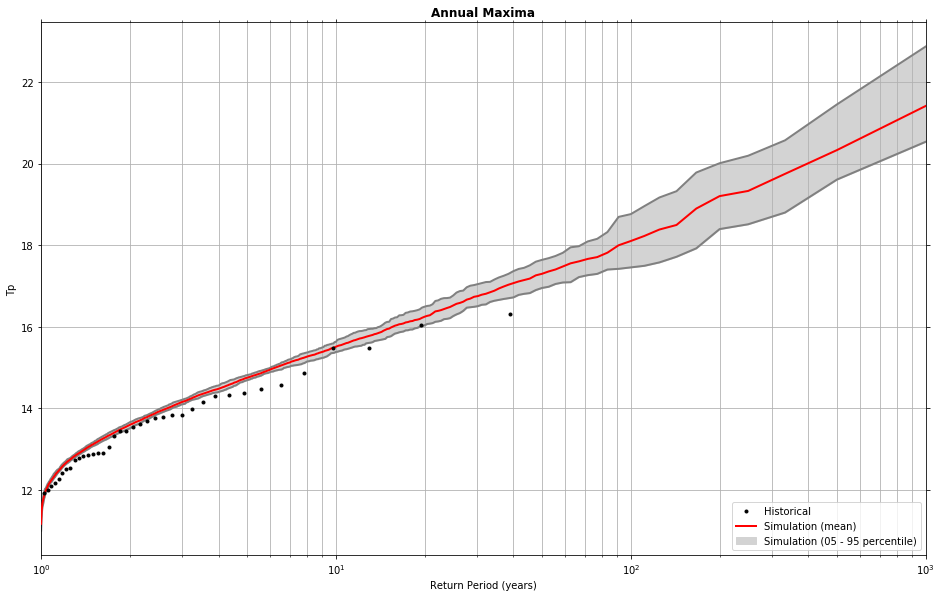

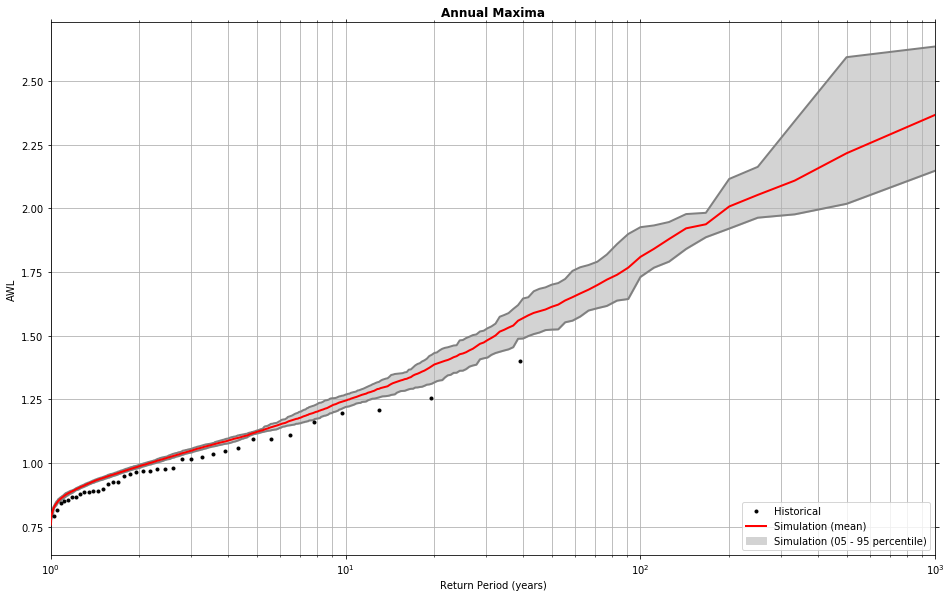

In [10]:
# Annual Maxima: Hs, Tp and AWL
vns = ['Hs', 'Tp', 'AWL']

for vn in vns:
    
    # get annual maxima
    hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
    sim_A = WVS_sim_a[vn].groupby('time.year').max(dim='time')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    

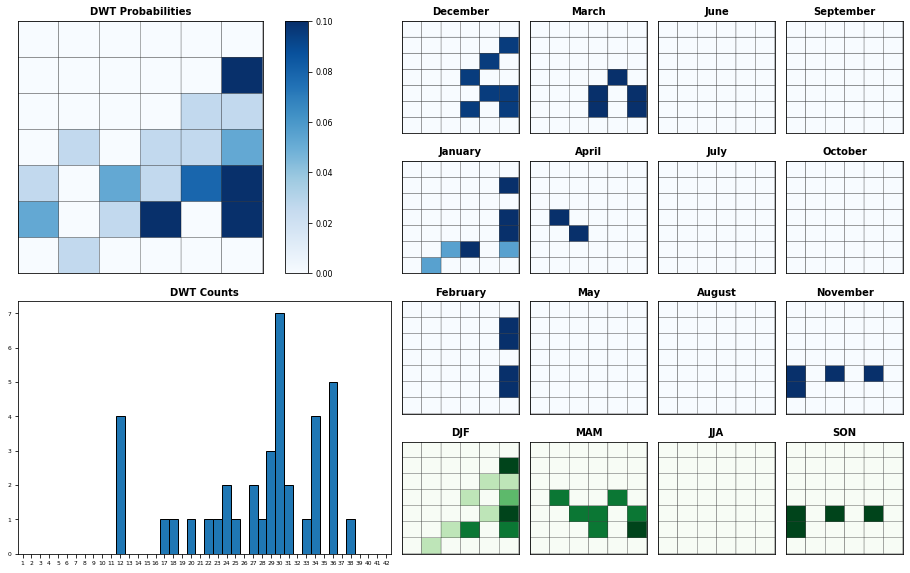

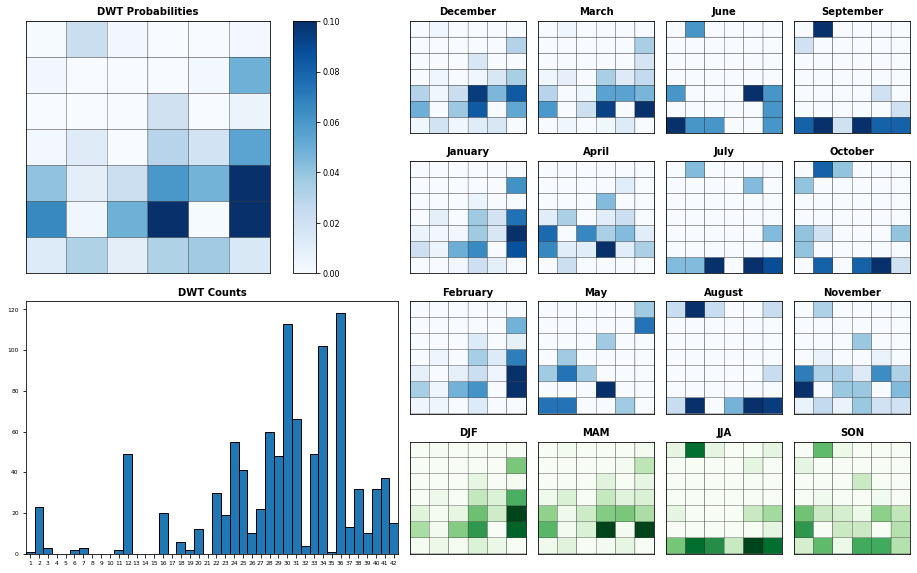

In [11]:
# Annual Maxima DWT probabilities 

vn = 'AWL'
WVS_sim_0 = WVS_sim_a.isel(n_sim=0)  # select simulation. TODO: use all sims?
n_clusters = 42


# aux func to select all dataset variables at max by groups
def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})

# Annual maxima dates
hist_Max = WVS_hist.groupby('time.year').apply(grouped_max, vn=vn, dim='time').time.values[:]
sim_Max = WVS_sim_0.groupby('time.year').apply(grouped_max, vn=vn, dim='time').time.values[:]


# DWTs at AWL annual maxima
hist_DWTs = DWTs_fit.sel(time=hist_Max).bmus
sim_DWTs = WVS_upd.sel(time=sim_Max, n_sim=0).DWT


# Plot DWTs probabilities by month
Plot_DWTs_Probs(hist_DWTs, hist_Max, n_clusters);
Plot_DWTs_Probs(sim_DWTs, sim_Max, n_clusters);


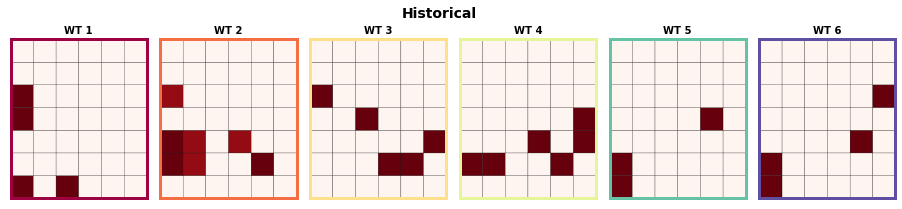

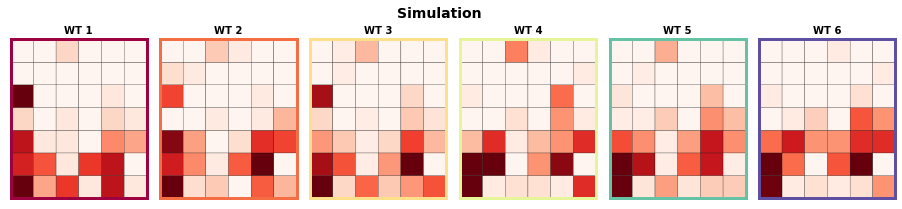

In [12]:
# Annual Maxima AWTs/DWTs Probabilities 

n_clusters_AWT = 6
n_clusters_DWT = 42


# Load historical and simulated AWTs
AWT_hist, _ = db.Load_AWTs_DWTs_Plots_hist()
AWT_sim, _ = db.Load_AWTs_DWTs_Plots_sim(n_sim=0)

# Select data at annual maxima
hist_AWTs = AWT_hist.sel(time=hist_Max).bmus.values[:]
sim_AWTs = AWT_sim.sel(time=sim_Max).bmus.values[:]


# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    hist_AWTs, hist_DWTs, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Historical'
);
Plot_Probs_WT_WT(
    sim_AWTs, sim_DWTs, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation'
);



## Climate Emulator - Peaks Over Threshold

In [13]:
# --------------------------------------
# Extremes POT

vn = 'AWL'
percentile=99
n_clusters = 42
WVS_sim_0 = WVS_sim_a.isel(n_sim=0) # select simulation


# Get independent event peaks
hist_POT = POT(WVS_hist, vn, percentile)
sim_POT = POT(WVS_sim_0, vn, percentile)


sim_POT.to_netcdf('test_sim_POT.nc')

# TODO
#Plot_PeaksOverThreshold(hist_POT)
#Plot_PeaksOverThreshold(sim_POT)

In [14]:
# POT Return Period

# TODO
#Plot_ReturnPeriodValidation(hist_POT, sim_POT);


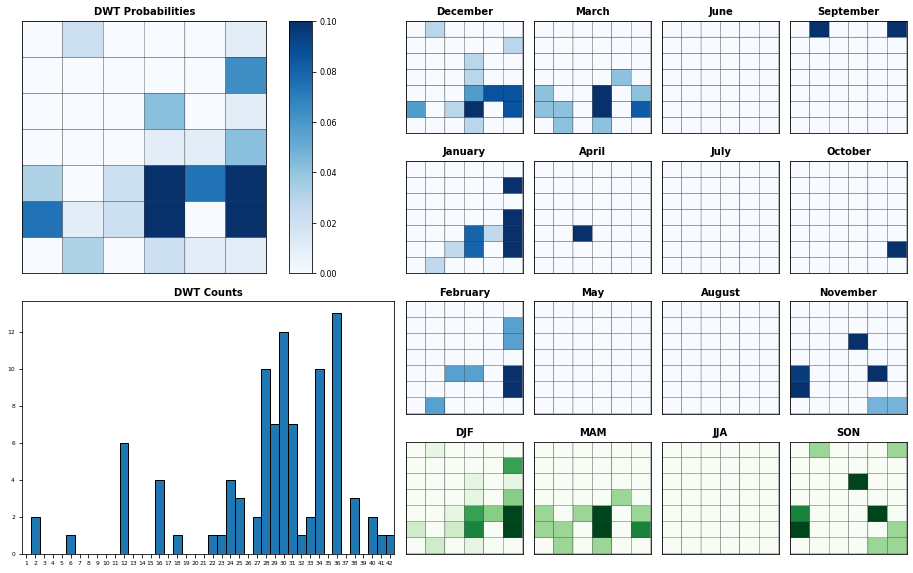

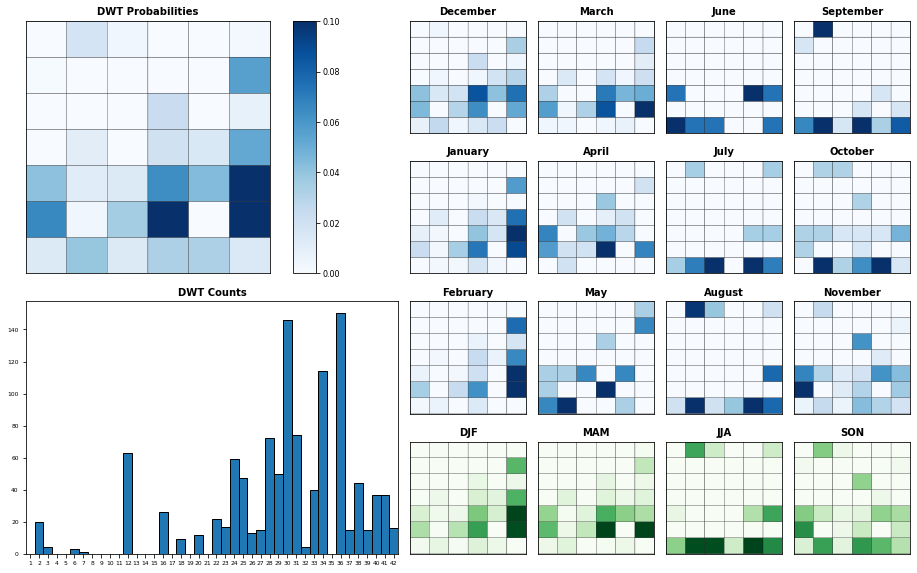

In [15]:
# POT DWT probabilities 

# DWTs at AWL annual maxima
hist_DWTs = DWTs_fit.sel(time=hist_POT.time).bmus
sim_DWTs = WVS_upd.sel(time=sim_POT.time, n_sim=0).DWT


# Plot DWTs probabilities by month
Plot_DWTs_Probs(hist_DWTs, hist_POT.time.values[:], n_clusters);
Plot_DWTs_Probs(sim_DWTs, sim_POT.time.values[:], n_clusters);


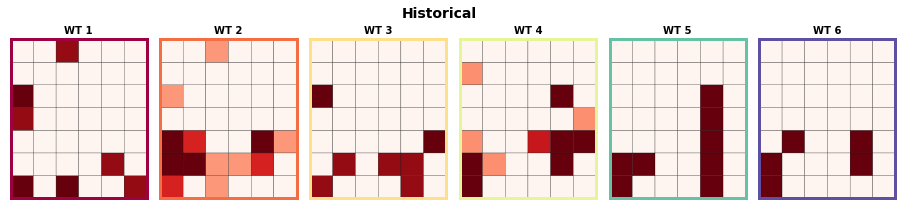

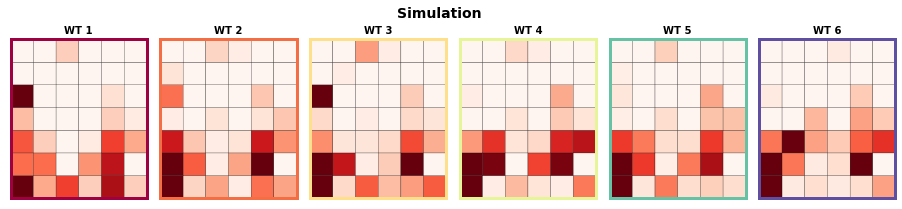

In [16]:
# POT AWTs/DWTs Probabilities 

# Select data at annual maxima
hist_AWTs = AWT_hist.sel(time=hist_POT.time).bmus.values[:]
sim_AWTs = AWT_sim.sel(time=sim_POT.time).bmus.values[:]


# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    hist_AWTs, hist_DWTs, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Historical'
);
Plot_Probs_WT_WT(
    sim_AWTs, sim_DWTs, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation'
);
